In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
#download = requests.get('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
#with open(r'C:\Users\Abdullahi Mujaheed\Desktop\mlzoom\bank_marketing.csv', 'wb') as link:
#    link.write(download.content)'''

In [3]:
#print(download.status_code)

In [4]:
def load_data(path):
    df = pd.read_csv(path)
    return df

In [5]:
bank_data = load_data(r'C:\Users\Abdullahi Mujaheed\Desktop\mlzoom\bank_marketing.csv')
bank_data.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
print(bank_data.shape, '\n', bank_data.dtypes, '\n', bank_data.isna().sum())

(1462, 9) 
 lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object 
 lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [7]:
def fill_na(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] =df[col].fillna('NA')
        else:
            df[col] = df[col].fillna(0)
    return df

In [8]:
bank_clean = fill_na(bank_data)
type(bank_clean)

pandas.core.frame.DataFrame

In [9]:
bank_clean.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

question 1: the mode value in the industry feature of the data

In [10]:
#len(bank_clean[bank_clean['industry'] == 'retail'])
bank_clean['industry'].value_counts()

industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64

In [11]:
import seaborn as sns

In [12]:
bank_corr = bank_clean.corr(numeric_only=True)

<Axes: >

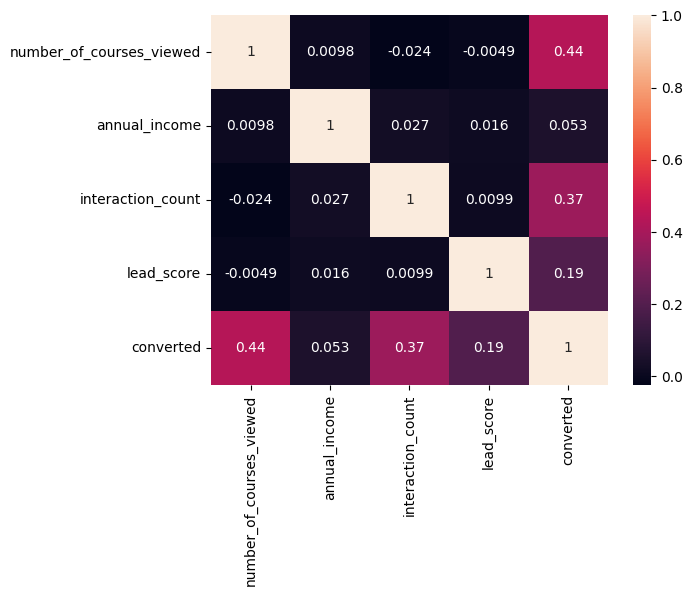

In [13]:
sns.heatmap(bank_corr, annot=True)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
bank_y = bank_clean['converted']

In [16]:
bank_X = bank_clean.drop(['converted'], axis=1)

In [17]:
train, val = train_test_split(bank_X, test_size=0.4, random_state=42)

In [18]:
val_y, test = train_test_split(val, test_size=0.5, random_state=42)

In [19]:
print(train.shape, val_y.shape, test.shape)

(877, 8) (292, 8) (293, 8)


In [ ]:
from sklearn.feature_selection import mutual_info_classif

y = bank_clean['converted']
cat_cols = bank_clean.select_dtypes(include=['object']).columns.tolist()#creturns a list of categorical or text columns

mi_scores = {}
for col in cat_cols:
    # encode categories as integers
    x_enc = pd.Series(pd.factorize(bank_clean[col])[0]).values.reshape(-1, 1)
    mi = mutual_info_classif(x_enc, y, discrete_features=True, random_state=42)
    mi_scores[col] = mi[0]

mi_df = pd.DataFrame.from_dict(mi_scores, orient='index', columns=['mutual_info']).sort_values('mutual_info', ascending=False)
print(mi_df)

                   mutual_info
lead_source           0.026574
employment_status     0.011070
industry              0.007267
location              0.001427


In [28]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [76]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

(1462, 9)

In [33]:
cols = bank_clean.select_dtypes(include=['object']).columns.tolist()

In [35]:
ohe.fit(train[cols])

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [36]:
cols_ohe = ohe.get_feature_names_out(cols) 
print(cols_ohe)

['lead_source_NA' 'lead_source_events' 'lead_source_organic_search'
 'lead_source_paid_ads' 'lead_source_referral' 'lead_source_social_media'
 'industry_NA' 'industry_education' 'industry_finance'
 'industry_healthcare' 'industry_manufacturing' 'industry_other'
 'industry_retail' 'industry_technology' 'employment_status_NA'
 'employment_status_employed' 'employment_status_self_employed'
 'employment_status_student' 'employment_status_unemployed' 'location_NA'
 'location_africa' 'location_asia' 'location_australia' 'location_europe'
 'location_middle_east' 'location_north_america' 'location_south_america']


In [38]:
train_ohe = pd.DataFrame(ohe.transform(train[cols]), columns=cols_ohe, index=train.index)
val_df = val_y  # your second split was stored in val_y
val_ohe = pd.DataFrame(ohe.transform(val_y[cols]), columns=cols_ohe, index=val_y.index)
test_ohe = pd.DataFrame(ohe.transform(test[cols]), columns=cols_ohe, index=test.index)

# keep numeric columns from original sets
train_num = train.select_dtypes(include=[np.number])
val_num = val_df.select_dtypes(include=[np.number])
test_num = test.select_dtypes(include=[np.number])

In [39]:
# concatenate numeric + one-hot
train_prepared = pd.concat([train_num, train_ohe], axis=1)
val_prepared   = pd.concat([val_num,   val_ohe], axis=1)
test_prepared  = pd.concat([test_num,  test_ohe], axis=1)

In [40]:
print("shapes:", train_prepared.shape, val_prepared.shape, test_prepared.shape)

shapes: (877, 31) (292, 31) (293, 31)


In [43]:
train_y, val_y = train_test_split(bank_y, test_size=0.4, random_state=42)

In [44]:
val_y, test_y = train_test_split(val_y, test_size=0.5, random_state=42)

In [45]:
print(train_y.shape, val_y.shape, test_y.shape)

(877,) (292,) (293,)


In [73]:
len(train_prepared.columns)

31

In [75]:
witout_industry = train_prepared.drop([col for col in train_prepared.columns if 'industry' in col], axis=1)
len(witout_industry.columns)

23

In [ ]:
lr.fit(train_prepared)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [47]:
eval_pred = lr.predict(val_prepared)

In [48]:
from sklearn.metrics import accuracy_score

In [88]:
eval_acc = accuracy_score(eval_pred, val_y)

In [89]:
print(f'the validation acc_score is {eval_acc}')

the validation acc_score is 0.7431506849315068


In [70]:
c_ = [0.01, 0.1, 1, 10, 100]
for c in c_:
    lr = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    lr.fit(train_prepared, train_y)
    eval_pred = lr.predict(val_prepared)
    eval_acc = accuracy_score(eval_pred, val_y)
    print(eval_acc)

0.7431506849315068
0.7431506849315068
0.7431506849315068
0.7431506849315068
0.7431506849315068


In [78]:
train_witout_industry = train_prepared.drop([col for col in train_prepared.columns if 'industry' in col], axis=1)
val_witout_industry = val_prepared.drop([col for col in val_prepared.columns if 'industry' in col], axis=1)
test_witout_industry = test_prepared.drop([col for col in test_prepared.columns if 'industry' in col], axis=1)

In [79]:
lr.fit(train_witout_industry, train_y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
val_without_industry_pred = lr.predict(val_witout_industry)
val_without_industry_acc = accuracy_score(val_without_industry_pred, val_y)
print(f'the validation acc_score without industry is {val_without_industry_acc}')

the validation acc_score without industry is 0.74


In [90]:
final_indus = 0.7431506849315068 - val_without_industry_acc
print(f'the final impact of industry is {final_indus}')

the final impact of industry is 0.003150684931506831


In [82]:
train_witout_employment = train_prepared.drop([col for col in train_prepared.columns if 'employment' in col], axis=1)
val_witout_employment = val_prepared.drop([col for col in val_prepared.columns if 'employment' in col], axis=1)
test_witout_employment = test_prepared.drop([col for col in test_prepared.columns if 'employment' in col], axis=1)

In [83]:
lr.fit(train_witout_employment, train_y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
val_without_employment_pred = lr.predict(val_witout_employment)
val_without_employment_acc = accuracy_score(val_without_employment_pred, val_y)
print(f'the validation acc_score without employment is {val_without_employment_acc}')

the validation acc_score without employment is 0.75


In [91]:
final_emp = 0.7431506849315068 - val_without_employment_acc
print(f'the final impact of employment is {final_emp}')

the final impact of employment is -0.006849315068493178


In [85]:
train_witout_lead_source = train_prepared.drop([col for col in train_prepared.columns if 'lead_source' in col], axis=1)
val_witout_lead_source = val_prepared.drop([col for col in val_prepared.columns if 'lead_source' in col], axis=1)
test_witout_lead_source = test_prepared.drop([col for col in test_prepared.columns if 'lead_source' in col], axis=1)

In [86]:
lr.fit(train_witout_lead_source, train_y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
val_without_lead_source_pred = lr.predict(val_witout_lead_source)
val_without_lead_source_acc = accuracy_score(val_without_lead_source_pred, val_y)
print(f'the validation acc_score without lead_source is {val_without_lead_source_acc}')

the validation acc_score without lead_source is 0.73


In [92]:
final_lead = 0.7431506849315068 - val_without_lead_source_acc
print(f'the final impact of lead_source is {final_lead}')

the final impact of lead_source is 0.01315068493150684
